# Data Challenge : Historical consumption regression for electricity supply pricing
-----------------------------
### __Catboost predictions__

## Importings and data preparations 

In [58]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import math
import holidays

# set plotting style
plt.style.use('fivethirtyeight')
figparams = {'figsize':(20,8), 'lw':0.8}

#Import training data
inputFilePath = "./input_training_ssnsrY0.csv"
data_train = pd.read_csv(inputFilePath, delimiter = ',', skiprows = 0, index_col=[0])

#Import testing data
inputFilePathTest = "./input_test_cdKcI0e.csv"
data_test = pd.read_csv(inputFilePathTest, delimiter = ',', skiprows = 0, index_col=[0])
id_test = data_test.index

# import targets
outputFilePath = "./output_training_Uf11I9I.csv"
targets = pd.read_csv(outputFilePath, delimiter = ',', skiprows = 0, index_col=[0])

#Remove useless datas
data_train = data_train.drop(["loc_1", "loc_2", "loc_secondary_1", "loc_secondary_2", "loc_secondary_3"], axis = 1)
data_test = data_test.drop(["loc_1", "loc_2", "loc_secondary_1", "loc_secondary_2", "loc_secondary_3"], axis = 1)

####### Features preparation ########
data_train.timestamp = pd.to_datetime(data_train.timestamp)
data_test.timestamp = pd.to_datetime(data_test.timestamp)

fr_holidays = holidays.France()
data_train['isHoliday'] = data_train.timestamp.apply(lambda x:1 if x in fr_holidays else 0)
data_test['isHoliday'] = data_test.timestamp.apply(lambda x:1 if x in fr_holidays else 0)

# indexing with timestamp
data_test = data_test.set_index('timestamp')
data_train = data_train.set_index('timestamp')

# time features 
def timefeatures(df):
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.weekofyear
    df['dayofweek'] = df.index.dayofweek

    return df

data_train = timefeatures(data_train)
data_test = timefeatures(data_test)

# isWeekend feature
data_train['isWeekend'] = data_train['dayofweek'].apply(lambda x: 1 if x in [5,6] else 0)
data_test['isWeekend'] = data_test['dayofweek'].apply(lambda x: 1 if x in [5,6] else 0)

# smoothing temp and humidity
data_train['temp_1_smooth7D'] = data_train['temp_1'].interpolate().rolling(24*7).mean().fillna(method='bfill').round(decimals=1)
data_train['temp_2_smooth7D'] = data_train['temp_2'].interpolate().rolling(24*7).mean().fillna(method='bfill').round(decimals=1)
data_test['temp_1_smooth7D'] = data_test['temp_1'].interpolate().rolling(24*7).mean().fillna(method='bfill').round(decimals=1)
data_test['temp_2_smooth7D'] = data_test['temp_2'].interpolate().rolling(24*7).mean().fillna(method='bfill').round(decimals=1)

data_train['humidity_1_smooth7D'] = data_train['humidity_1'].interpolate().rolling(24*7).mean().fillna(method='bfill').round()
data_train['humidity_2_smooth7D'] = data_train['humidity_2'].interpolate().rolling(24*7).mean().fillna(method='bfill').round()
data_test['humidity_1_smooth7D'] = data_test['humidity_1'].interpolate().rolling(24*7).mean().fillna(method='bfill').round()
data_test['humidity_2_smooth7D'] = data_test['humidity_2'].interpolate().rolling(24*7).mean().fillna(method='bfill').round()

# concatenate features and targets
data_train = pd.concat([targets.set_index(data_train.index), data_train],axis=1)

C:\Users\mehdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [59]:
# import catboost regressor
from catboost import CatBoostRegressor

# Location 1

### Features selection

In [60]:
features_lm_loc1 =['hour',"isWeekend",'isHoliday','dayofweek','month','weekofyear','consumption_secondary_1', 
                   'consumption_secondary_2','consumption_secondary_3','temp_1','humidity_1'] 

# training data
X_train1 = data_train[features_lm_loc1]
# training labels
y_train1 = data_train['consumption_1']

# test data
X_test1 = data_test[features_lm_loc1]

### Model 1

In [61]:
model1 = CatBoostRegressor(
    iterations=1000,
    random_seed=12,
    logging_level='Silent',
    loss_function='MAE'
)

model1.fit(
    X_train1, y_train1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Generating predictions

<AxesSubplot:xlabel='timestamp'>

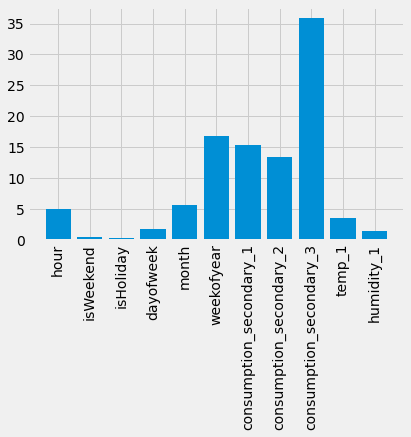

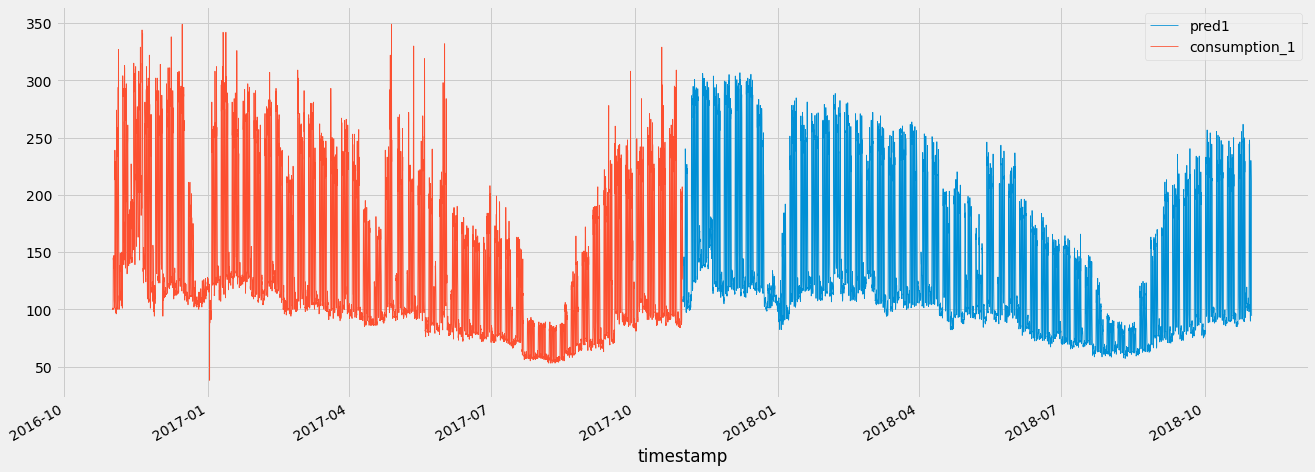

In [62]:
# predictions
pred1 = model1.predict(X_test1)
pred1_df = pd.DataFrame(pred1, index = data_test.index, columns=['pred1'])

# plotting coefficients' importances
plt.bar(features_lm_loc1, model1.feature_importances_)
plt.xticks(rotation=90)

# plotting predictions
pred1_df.plot(**figparams, legend=True)
y_train1.plot(**figparams, legend=True)

# Location 2

### Features selection

In [63]:
features_lm_loc2 =['hour','isWeekend','isHoliday','dayofweek','month','weekofyear','consumption_secondary_1',
                   'consumption_secondary_2','consumption_secondary_3','temp_2_smooth7D','humidity_2_smooth7D'] 

#training data
X_train2 = data_train[features_lm_loc2]
# training labels
y_train2 = data_train['consumption_2']

# test data
X_test2 = data_test[features_lm_loc2]

### Model 2

In [64]:
model2 = CatBoostRegressor(
    iterations=300,
    random_seed=12,
    logging_level='Silent',
    loss_function='MAE'
)

model2.fit(
    X_train2, y_train2,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Generating predictions

<AxesSubplot:xlabel='timestamp'>

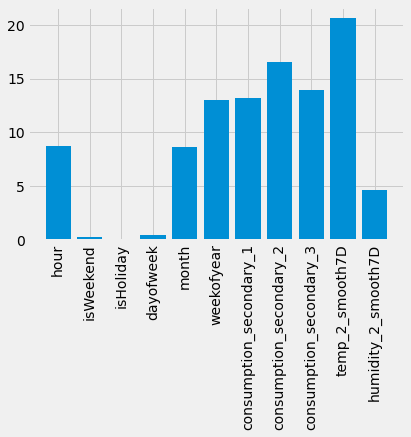

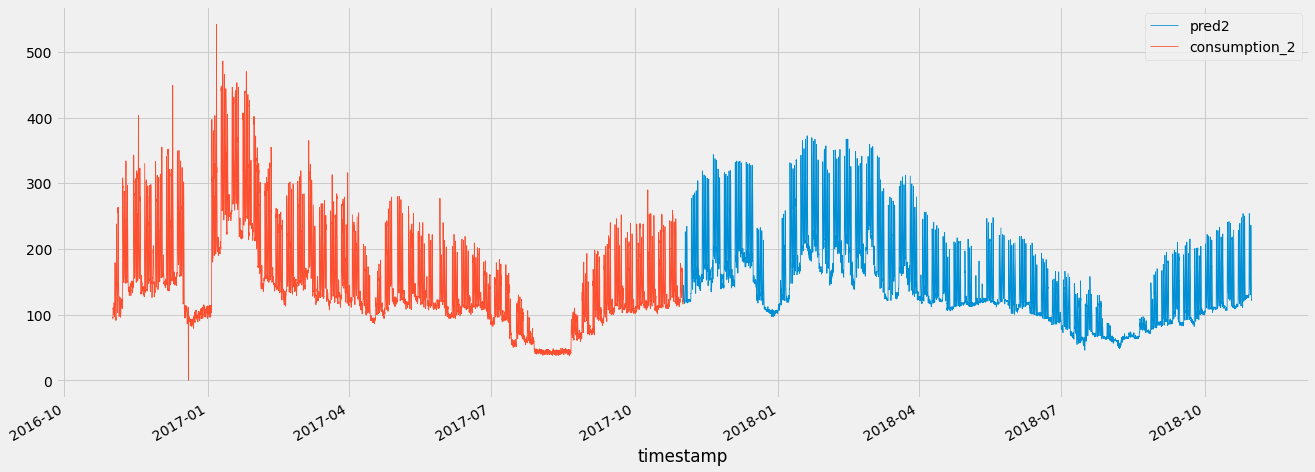

In [65]:
# predictions
pred2 = model2.predict(X_test2)
pred2_df = pd.DataFrame(pred2, index = data_test.index, columns=['pred2'])

# plotting coefficients' importances
plt.bar(features_lm_loc2, model2.feature_importances_)
plt.xticks(rotation=90)

# plotting predictions
pred2_df.plot(**figparams, legend=True)
y_train2.plot(**figparams, legend=True)

# Submission

In [66]:
sub_cb = pd.concat([pred1_df.round(1),pred2_df.round(1)], axis=1).set_index(id_test)
sub_cb.to_csv('submission.csv') 

### Public Score:
Weighted Mean Absolute Error = 18.61